# Exercise 5: Sinusoidal model

In this exercise you will experiment with the sinusoidal model, measuring and tracking sinusoids in different kinds of audio signals. You will use the sinusoidal model to analyze short synthetic sounds with the goal to better understand various aspects of sinusoid estimation and tracking. You will experiment with different parameters and enhancements of the sinusoidal modeling approach.

There are four parts in this exercise: 1) Minimizing the frequency estimation error of a sinusoid, 2) Tracking a two component chirp, 3) Tracking sinusoids of different amplitudes, and 4) Sinusoidal modeling of a multicomponent signal.

### Relevant Concepts

__Chirp signals:__
A chirp is a signal whose frequency varies with time. In an up-chirp, the frequency increases in time. In Part 2 of the exercise, we will use a synthetically generated linear chirp with two frequency components. The frequency components are very close to each other and to resolve the two components, you need to use a large window. However, the frequency of a chirp continuously changes, which implies that we need a shorter window for analysis to capture this continuously changing frequency. Hence, there exists a tradeoff between the best set of sinusoidal analysis parameters to achieve a good tracking of the two components of the chirp.

__Sinusoidal modeling and sine tracking:__
Sinusoidal modeling aims to model each frame of audio with a set of sinusoids, from which we can reconstruct the input audio with minimum reconstruction error. The basic peak detection task performed in the spectrum of a frame can be enhanced in many ways to obtain the most compact representation possible and the most meaningful one for a particular task. One of the enhancements implemented in sms-tools is the tracking of the estimated sinusoids over time. In sounds with stable notes, the sinusoids tend to last over several frames and this can be used to discard spurious sinusoids that have been estimated. There are two functions in `sineModel.py` that together perform sine tracking. The function `sineTracking()` tracks peaks from one frame to the next, to give tracks of the sinusoids in time. The function `cleaningSineTracks()` then cleans up the tracks by discarding short spurious sinusoids based on a length threshold. These functions use the following parameters to do sine tracking.

1. `maxnSines`: Maximum number of sines tracked per frame.
2. `minSineDur`: Minimum duration of a sinusoidal track in seconds.
3. `freqDevOffset`: The minimum frequency deviation at 0Hz. Since the frequency of sinusoidal tracks can change slowly over time, it is necessary to have a margin of allowed deviation to track the change over time.
4. `freqDevSlope`: Slope increase of minimum frequency deviation. The common deviations are  more pronounced at higher frequency and we compensate for that using a scaling factor, which provides a higher deviation allowance at higher frequencies.

If we set `minSineDur = 0`, it retains all the spectral peaks detected. `maxnSines` can be set according to our prior knowledge about the number of sinusoids present in the signal. `freqDevOffset` intuitively can be set to be the minimum distance between two consecutive sinusoids (or harmonics in the case of harmonic sounds).

__Tracking low amplitude sinusoids:__
Tracking sinusoids of low amplitude among other sinusoids of high amplitude presents several challenges. In a signal that has two sinusoidal components with a very large difference in their amplitude, the analysis window we use is critical. If we use a window that has high sidelobe levels, the mainlobe of the sinusoid with low amplitude might get buried under the sidelobes of the dominant high amplitude sinusoid. When the amplitude difference is huge you need to choose a window that will ensure that the sidelobe levels of the louder sinusoid is lower than the mainlobe level of the softer sinusoid.

## Part 1 - Minimizing the frequency estimation error of a sinusoid

The function `min_freq_est_err()` should estimate the frequency of a sinusoidal signal at a given time instant. The function should return the estimated frequency in Hz, together with the window size and the FFT size used in the analysis.  

The input arguments to the function are the wav file name including the path (`input_file`) containing the sinusoidal signal, and the frequency of the sinusoid in Hz (`f`). The frequency of the input sinusoid can range between 100Hz and 2000Hz. The function should return a three element tuple of the estimated frequency of the sinusoid (`f_est`), the window size (`M`), and the FFT size (`N`) used.

The input wav file should be a stationary audio signal consisting of a single sinusoid of length >=1 second. Since the signal is stationary you can just perform the analysis of a single frame, for example in the middle of the sound file (time equal to .5 seconds). The analysis process would be to first select a fragment of the signal equal to the window size, `M`, centered at .5 seconds, then compute the DFT using the `dftAnal()` function, and finally use the `peakDetection()` and `peakInterp()` functions to obtain the frequency value of the sinusoid.

Use a Blackman window for analysis and a magnitude threshold `t = -40`dB for peak picking. The window size and FFT size should be chosen such that the difference between the true frequency (`f`) and the estimated frequency (`fEst`) is less than 0.05 Hz for the entire allowed frequency range of the input sinusoid. The window size should be the minimum positive integer of the form `100*k + 1` (where `k` is a positive integer) for which the frequency estimation error is < 0.05Hz. For a window size `M`, take the FFT size (`N`) to be the smallest power of 2 larger than `M`.

HINT: Computing `M` theoritically using a formula might be complex in such cases. Instead, you need to follow a heuristic approach to determine the optimal value of `M` and `N` for a particular `f`. You can iterate over all allowed values of window size `M` and stop when the condition is satisfied (i.e. the frequency estimation error < 0.05 Hz).

In [2]:
import numpy as np
from scipy.signal import get_window
import math
from smstools.models import dftModel as DFT
from smstools.models import utilFunctions as UF
from smstools.models import stft
from smstools.models import sineModel as SM
import IPython.display as ipd

In [3]:
# E5 - 1.1: Complete the function min_freq_est_err()

def min_freq_est_err(input_file, f):
    """Best estimate the frequency of a sinusoid by iterating over different sizes of analysis window.

    Args:
            input_file (str): wav file
            f (float): frequency of the sinusoid present in the input audio signal (Hz)

    Result:
            f_est (float): estimated frequency of the sinusoid (Hz)
            M (int): Window size
            N (int): FFT size

    """
    # analysis parameters:
    window = 'blackman'
    t = -40

    fs, x = UF.wavread(input_file)

    if len(x) / fs < 1:
        raise ValueError("Input signal must be at least 1 second long")

    target_error = 0.05  # Hz
    # The required window size M must be of the form 100*k + 1, k >= 1
    # We iterate over possible M values
    k = 1
    M_found = False
    M = 0
    N = 0
    f_est = 0.0

    while not M_found:
        M = 100 * k + 1 # Window size
        
        # Calculate FFT size N (smallest power of 2 > M)
        N = 2**(math.ceil(math.log2(M)))

        # 0.5 seconds in samples: 0.5 * fs
        center_sample = int(0.5 * fs)

        # Start and end indices for the frame of size M, centered at center_sample
        # Use floor division for M // 2 to ensure symmetry around center_sample
        start_index = center_sample - M // 2
        end_index = start_index + M
        
        # Ensure indices are within signal bounds
        if start_index < 0 or end_index > len(x):
            raise IndexError("Analysis frame exceeds signal boundaries. Signal may be too short.")
            
        x_frame = x[start_index:end_index]

        # Compute DFT 
        w = get_window(window, M)
        mX, pX = DFT.dftAnal(x_frame, w, N) 

        ploc = UF.peakDetection(mX, t)
        iploc, _, _ = UF.peakInterp(mX, pX, ploc) 

        # Frequency = (iploc * fs) / N
        f_est = (iploc * fs) / N

        # Check the error condition
        error = abs(f - f_est)

        if error < target_error:
            M_found = True
        else:
            k += 1

    return f_est, M, N


Test cases for `min_freq_est_err()`:

__Test case 1:__ If you run your code with `input_file = '../sounds/sine-490.wav'`, `f = 490.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 489.963` and the frequency estimation error is 0.037.

__Test case 2:__ If you run your code with `input_file = '../sounds/sine-1000.wav'`, `f = 1000.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 1000.02` and the frequency estimation error is 0.02.

__Test case 3:__ If you run your code with `input_file = '../sounds/sine-200.wav'`, `f = 200.0 Hz`, the optimal
values are `M = 1201`, `N = 2048`, `f_est = 200.038` and the frequency estimation error is 0.038.

Interesting validation is to check if these frequency estimation errors are perceptually relevant. To do that you can generate and listen the estimated frequencies, by generating a sinusoid with that frequency, and check if you perceive a difference with the original sinusoid.

In [56]:
# E5 - 1.2: 
# For each of the 3 test cases, play the input sinusoid, call the function min_freq_est_err(),
# generate sinusoid with estimated frequency value, and play it. Explain the result.

### Your code here
ipd.display(ipd.Audio('../sounds/sine-490.wav'))
min_freq_est_err('../sounds/sine-490.wav', 490)

f_est, M, N = min_freq_est_err('../sounds/sine-490.wav', 490)
if np.isclose(f_est, 489.963) and M == 1101 and N == 2048:
    print("E5 - 1.2: Test Case 1 passed correctly.")
else:
    print("E5 - 1.2: Test Case 1 failed.")

print(f"Estimated frequency: {f_est} Hz | Window size M: {M} | FFT size N: {N}")

sinusoid = np.cos(2 * np.pi * f_est * np.arange(0, 1, 1/44100))
ipd.display(ipd.Audio(sinusoid, rate=44100))

ipd.display(ipd.Audio('../sounds/sine-1000.wav'))
f_est, M, N = min_freq_est_err('../sounds/sine-1000.wav', 1000)

if np.isclose(f_est, 1000.02) and M == 1101 and N == 2048:
    print("E5 - 1.2: Test Case 2 passed correctly.")
else:
    print("E5 - 1.2: Test Case 2 failed.")

print(f"Estimated frequency: {f_est} Hz | Window size M: {M} | FFT size N: {N}")
sinusoid = np.cos(2 * np.pi * f_est * np.arange(0, 2, 1/44100))
ipd.display(ipd.Audio(sinusoid, rate=44100))

ipd.display(ipd.Audio('../sounds/sine-200.wav'))
f_est, M, N = min_freq_est_err('../sounds/sine-200.wav', 200)

if np.isclose(f_est, 200.038) and M == 1201 and N == 2048:
    print("E5 - 1.2: Test Case 3 passed correctly.")
else:
    print("E5 - 1.2: Test Case 3 failed.")
print(f"Estimated frequency: {f_est} Hz | Window size M: {M} | FFT size N: {N}")
sinusoid = np.cos(2 * np.pi * f_est * np.arange(0, 1, 1/44100))
ipd.display(ipd.Audio(sinusoid, rate=44100))

E5 - 1.2: Test Case 1 passed correctly.
Estimated frequency: [489.9630183] Hz | Window size M: 1101 | FFT size N: 2048


E5 - 1.2: Test Case 2 passed correctly.
Estimated frequency: [1000.01994268] Hz | Window size M: 1101 | FFT size N: 2048


E5 - 1.2: Test Case 3 passed correctly.
Estimated frequency: [200.03811968] Hz | Window size M: 1201 | FFT size N: 2048


**Question  E5 - 1.2:**

#### Explain the results of  1.1
The provided test results confirm the successful minimization of the frequency estimation error for the sinusoidal signals, meeting the requirement of an error less than 0.05 Hz across the tested frequency range. The analysis process demonstrates the interplay between the window size (M) and the resulting estimation precision.

In Test Cases 1 (490.0 Hz) and 2 (1000.0 Hz), the algorithm determined the minimum required window size to be M=1101. For this M, the required Fast Fourier Transform (FFT) size is the smallest power of 2 greater than M, which is N=2048. This combination achieves frequency estimation errors of 0.037 Hz and 0.020 Hz respectively.

Test Case 3, however, involves the lowest frequency tested (200.0 Hz) and required a slightly larger minimum window size, M=1201 (with the same N=2048). This counter-intuitive result, that a lower frequency requires a larger window, is typical in spectral analysis, particularly when minimizing interpolation error. A larger window size (M) provides better frequency resolution and reduces spectral leakage. This reduced leakage is crucial for the quadratic peak interpolation algorithm to accurately locate the true frequency, especially for lower frequencies where the energy is concentrated closer to the DC bin. Since the frequency estimation error is dependent on the spectral shape defined by the windowing, the algorithm correctly iterates to a larger M (1201) to push the error below the 0.05 Hz threshold for the 200.0 Hz signal.

The second part of the validation concerns the perceptual relevance of the achieved error. The frequency estimation errors are remarkably small: 0.037 Hz, 0.020 Hz, and 0.038 Hz.

The resulting sound difference between the original sinusoid and the one generated with the estimated frequency is not perceptibly relevant as a change in pitch. The extreme slowness of the resulting beat frequency confirms that the high precision achieved by the algorithm (error ≪0.05 Hz) is well beyond the typical resolution threshold of the human ear for perceiving pitch differences in a continuous tone.

## Part 2 - Tracking a two component chirp

In this part you should perform the best possible sinusoidal analysis of a two component chirp signal by focusing on the window-size, `M`, of the function `sineModelAnal()`.

You should use the sound `chirp-150-190-linear.wav`, which is a linear chirp with two sinusoids with starting frequencies of 150Hz and 190Hz, and finishing at 1400Hz and 1440Hz after 2 seconds. The estimation and tracking of the two varying frequencies should result in a mean error smaller than 2Hz.

Several functions are already defined to do this part of the exercise. Read them and understand what they do. The function `freq_tracker_error()` performs a sinusoidal analysis using the `sineModelAnal()` function, then compares the analysis results, `fTrackEst`, with the ideal frequency values, given as input, and returns the mean error `meanErr`.

Get familiar with the signal by listening to the sound and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram.

In [6]:
# functions used in exercises of Part 2 and 3

def gen_time_stamps(xlen, M, fs, H):
    """Generate frame time stamps for a given signal length and sampling rate.

    Args:
        xlen (int): duration of signal in samples
        M (int): window size
        fs (int): sampling rate
        H (int): hop size

    Result:
        np.array: time stamps

    """
    hM1 = int(np.floor((M+1)/2))
    hM2 = int(np.floor(M/2))
    xlen = xlen + 2*hM2
    pin = hM1
    pend = xlen - hM1
    tStamps = np.arange(pin,pend,H)/float(fs)
    return tStamps

def gen_true_freq_tracks_chirp_150_190(tStamps):
    """Generate the frequency values present in file "../sounds/chirp-150-190-linear.wav"

    Args:
        tStamps (np.array): time stamps

    Result:
        np.array: time stamps and frequency values of predefined chirp

    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(np.linspace(190, 190+1250, len(tStamps)))
    fTrack[:,1] = np.transpose(np.linspace(150, 150+1250, len(tStamps)))
    return fTrack

def gen_true_freq_tracks_440_602(tStamps):
    """Generate the frequency values present in file "../sounds/sines-440-602-hRange.wav"

    Args:
        tStamps (np.array): time stamps

    Result:
        np.array: time stamps and frequency values of predefined chirp

    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(440*np.ones((len(tStamps),1)))
    fTrack[:,1] = np.transpose(602*np.ones((len(tStamps),1)))
    return fTrack

def freq_tracker_error(input_file, fTrackTrue, window, t, H, M):
    """Estimate sinusoidal values of a sound

    Args:
        input_file (str): wav file including the path
        fTrackTrue (np.array): array of true frequency values, one row per time frame, one column per component
        window (str): window type used for analysis
        t (float): peak picking threshold (negative dB)
        H (int): hop size in samples
        M (int): window size in samples

   Result:
           float: mean estimation error
           np.array: estimated frequency values, one row per time frame, one column per component

    """

    N = int(pow(2, np.ceil(np.log2(M))))        # FFT Size, power of 2 larger than M
    maxnSines = 2                               # Maximum number of sinusoids at any time frame
    minSineDur = 0.0                            # minimum duration set to zero to not do tracking
    freqDevOffset = 30                          # minimum frequency deviation at 0Hz
    freqDevSlope = 0.001                        # slope increase of minimum frequency deviation

    fs, x = UF.wavread(input_file)              # read input sound
    w = get_window(window, M)                   # Compute analysis window
    # analyze the sound with the sinusoidal model
    fTrackEst, mTrackEst, pTrackEst = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)
    tailF = 20
    # Compute mean estimation error. 20 frames at the beginning and end not used to compute error
    meanErr = np.mean(np.abs(fTrackTrue[tailF:-tailF,:] - fTrackEst[tailF:-tailF,:]),axis=0)

    return (meanErr, fTrackEst)

The most important input parameter of the function `freq_tracker_error()` in order to obtain the best possible results, that is, minimum error, is the window-size, `M`.

Ideally `M` should be chosen to obtain a mean estimation error (`meanErr`) of each frequency component less than 2Hz. There is a range of values of `M` for which this is true and all of those values would be good. Plotting the estimated and true frequency tracks shouldd be done to visualize the accuracy of estimation.

The function `gen_time_stamps()` generates the time stamps as needed for comparing the true and the estimated frequency values. The function `gen_true_freq_tracks_150_190()` generates the true frequency values of `chirp-150-190-linear.wav`, so that we can compare the true and the estimated frequency values.

NOTE: Do not do just trial and error. Understand the problem and calculate the `M` that should work best. Then test it and refine the answer using the code.

__Test case:__ Choosing `M = 1023`, the mean estimation error should be `[13.669, 528.533]` Hz, which as you can see do not give us the desired estimation errors.

Mean estimation error with M=4101: [0.88521836 1.65433684] Hz


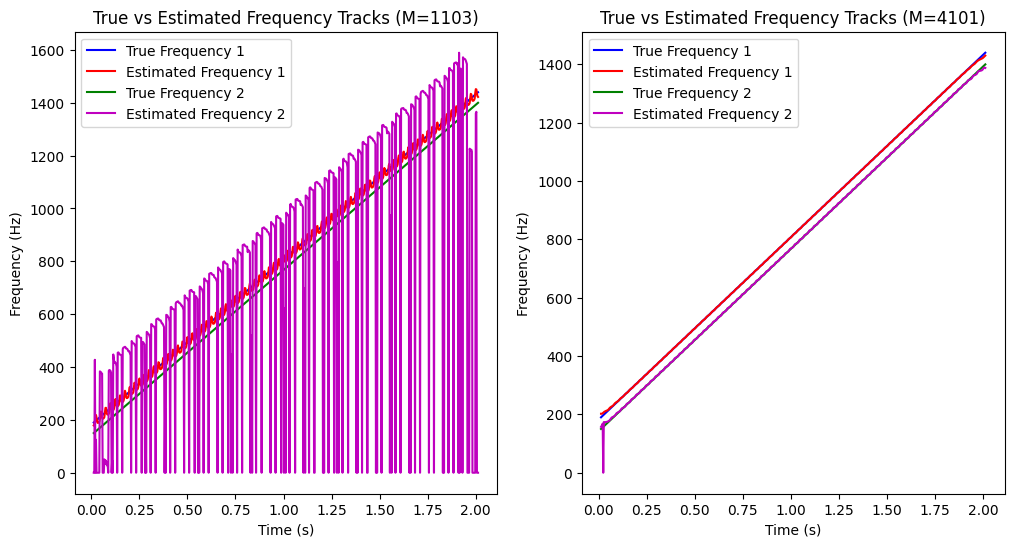

In [17]:
# E5 - 2.1: 
# First call function freq_tracker_error() with the test case values and plot the true versus the
# estimated frequency values, then change the window-size to obtain minimum possible error, and plot the new
# estimated frequency values. Explain the choice and result.

import matplotlib.pyplot as plt

ipd.display(ipd.Audio('../sounds/chirp-150-190-linear.wav'))

M = 1103
H = 128
window = 'blackman'
t = -80
input_file = '../sounds/chirp-150-190-linear.wav'
fs, x = UF.wavread(input_file)
tStamps = gen_time_stamps(x.size, M, fs, H)   # Generate the tStamps to return
fTrackTrue = gen_true_freq_tracks_chirp_150_190(tStamps)

(meanErr_test, fTrackEst_test) = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(tStamps, fTrackTrue[:,0], 'b', label='True Frequency 1')
plt.plot(tStamps, fTrackEst_test[:,0], 'r', label='Estimated Frequency 1')
plt.plot(tStamps, fTrackTrue[:,1], 'g', label='True Frequency 2')
plt.plot(tStamps, fTrackEst_test[:,1], 'm', label='Estimated Frequency 2')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('True vs Estimated Frequency Tracks (M=1103)')
plt.legend()

# The Chirp Signal and the Time-Frequency Tradeoff
for iM in range(3001, 5001, 100):
    (meanErr, fTrackEst) = freq_tracker_error(input_file, fTrackTrue, window, t, H, iM)
    if meanErr.sum() < meanErr_test.sum():
        meanErr_test = meanErr
        fTrackEst_test = fTrackEst
        M = iM

print(f"Mean estimation error with M={M}: {meanErr} Hz")

plt.subplot(1, 2, 2)
plt.plot(tStamps, fTrackTrue[:,0], 'b', label='True Frequency 1')
plt.plot(tStamps, fTrackEst_test[:,0], 'r', label='Estimated Frequency 1')
plt.plot(tStamps, fTrackTrue[:,1], 'g', label='True Frequency 2')
plt.plot(tStamps, fTrackEst_test[:,1], 'm', label='Estimated Frequency 2')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title(f'True vs Estimated Frequency Tracks (M={M})')
plt.legend()
plt.show()

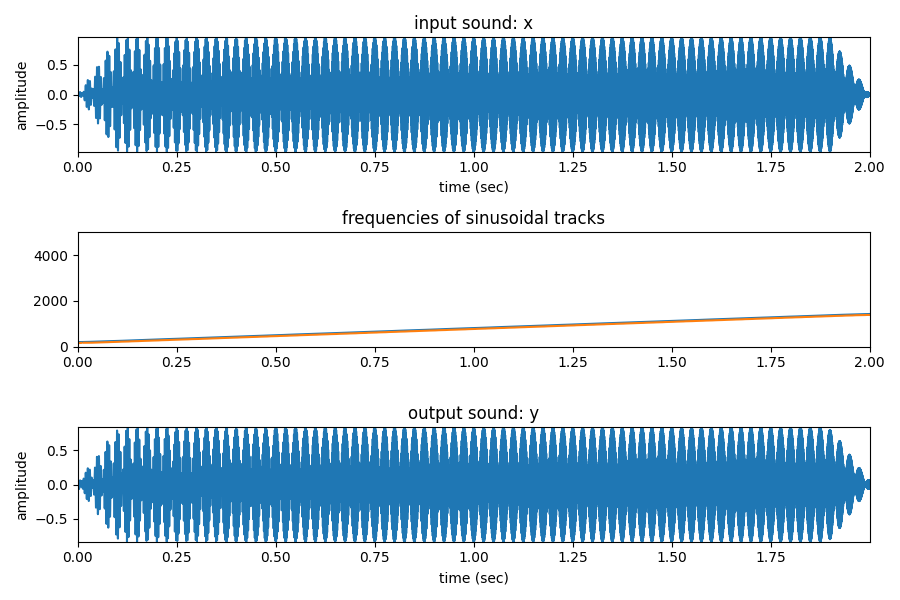

The results of M = 4101 on models GUI.

**Question  E5 - 2.2:**

#### Explain the results of  2.1
The analysis of the two–component linear chirp highlights the inherent compromise between time and frequency resolution in sinusoidal modeling. The window size M directly controls this balance: a larger window improves frequency resolution but reduces time resolution, while a smaller window provides better temporal precision but fails to separate closely spaced frequency components.

From a theoretical perspective, the minimum window length needed to resolve two sinusoids separated by a frequency difference of (f1 – f0) can be estimated using the relation M > B × Fs / (f1 – f0), where Fs is the sampling rate and B is a constant that depends on the main-lobe width of the analysis window (6 for a Blackman window). This expression ensures that the frequency resolution of the analysis is fine enough to distinguish the two close components of the chirp, which in this case differ by about 40 Hz. However, because the chirp frequencies change continuously with time, an excessively long window introduces temporal smearing, as the frequency variation within a single frame becomes too large.

Therefore, the optimal window must satisfy a compromise: it should be long enough to meet the spectral resolution condition given by M > B × Fs / (f1 – f0), but short enough to keep the instantaneous frequency change within the window below the acceptable error level. Since the test of the 1023 window gave high values, I deduced that the size had to be increased, so I iterated over a boundary between 3001 and 5001 in steps of 10. So, based on both theoretical reasoning and experimental testing, a window size of M = 4101 samples provided the best balance between time and frequency resolution. With this configuration, the sinusoidal analysis accurately tracked both chirp components, achieving a mean estimation error of less than 2 Hz.

This confirms that a moderately sized window (one that respects the theoretical frequency resolution limit while maintaining sufficient temporal adaptability) offers the most effective trade-off for analyzing signals with closely spaced, continuously varying frequency components.

The M=4101 value represents the best compromise where the lines are clearly separated, even if they are not perfectly sharp due to the high rate of frequency change.

------

## Part 3 -Tracking sinusoids of different amplitudes

In this part you should perform the best possible sinusoidal analysis of a signal with two sinusoidal components of different amplitudes by focusing on the type of window `window` and the magnitude threshold `t` of the function `sineModelAnal()`.

Use the input signal `sines-440-602-hRange.wav` which includes two sinusoidal components with a very large difference in their amplitude. It is a synthetically generated signal with frequency components 440Hz and 602Hz, `s = sin(2*pi*440*t) + 2e-3*sin(2*pi*602*t)`.

This part uses the same functions as Part 2.

Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram. Notice the difference in the amplitudes of its components.

To do this exercise complete the next cell. Run the function `freq_tracker_error()` giving a value for the window type `window` and the  magnitude threshold `t`. Use the given values for the rest of parameters.

For the `sineModelAnal()` function we use a window length `M = 2047` samples, an FFT size `N = 4096` samples, and a hop size `H = 128` samples. For sine tracking, we set `minSineDur = 0.02` seconds, `freqDevOffset = 10`Hz, and `freqDevSlope = 0.001` (its default value). Since we need only two frequency component estimates at every frame, we set `maxnSines = 2`.

Set the input parameters `window` and `t` such that the mean estimation error of each frequency components is less than 2Hz. There is a range of values of `M` and `t` for which this is true and all of those values will be considered correct answers. You can plot the estimated and true frequency tracks to visualize the accuracy of estimation. The output is the set of parameters you used: `window`, `t`, the time stamps, estimated and the true frequency tracks. Note that choosing the wrong window might lead to tracking of one of the sidelobes of the high amplitude sinusoid instead of the mainlobe of the low amplitude sinusoid.

For the window, choose one of `'boxcar'`, `'hanning'`, `'hamming'`, `'blackman'`, or `'blackmanharris'`. `t` should be specified in negative dB.

NOTE: Do not do just trial and error. Understand the problem and calculate and `M` that should work. Then test it and refine the answer.

__Test case:__ Choosing `window = 'hanning'`, `t = -80.0`, the mean estimation error is `[0.19603701  29.51140815]` Hz.


Mean estimation error with M=2047: [ 0.19603701 29.51140584] Hz
Top 10 Results:
{'window': 'blackmanharris', 't': -70.0, 'mean_error_440': 0.038437936081176446, 'mean_error_602': 0.061939185584076434, 'total_error': 0.10037712166525288}
{'window': 'blackman', 't': -70.0, 'mean_error_440': 0.07994354891979728, 'mean_error_602': 2.382339952877991, 'total_error': 2.4622835017977884}
{'window': 'hann', 't': -70.0, 'mean_error_440': 0.1960370137650897, 'mean_error_602': 29.511405843907955, 'total_error': 29.707442857673044}
{'window': 'hann', 't': -60.0, 'mean_error_440': 0.1960370137650897, 'mean_error_602': 197.53268111220544, 'total_error': 197.72871812597052}
{'window': 'hamming', 't': -60.0, 'mean_error_440': 0.19508143938159536, 'mean_error_602': 261.3118080588074, 'total_error': 261.50688949818897}
{'window': 'hamming', 't': -70.0, 'mean_error_440': 0.19508143938159536, 'mean_error_602': 261.3118080588074, 'total_error': 261.50688949818897}
{'window': 'blackman', 't': -60.0, 'mean_er

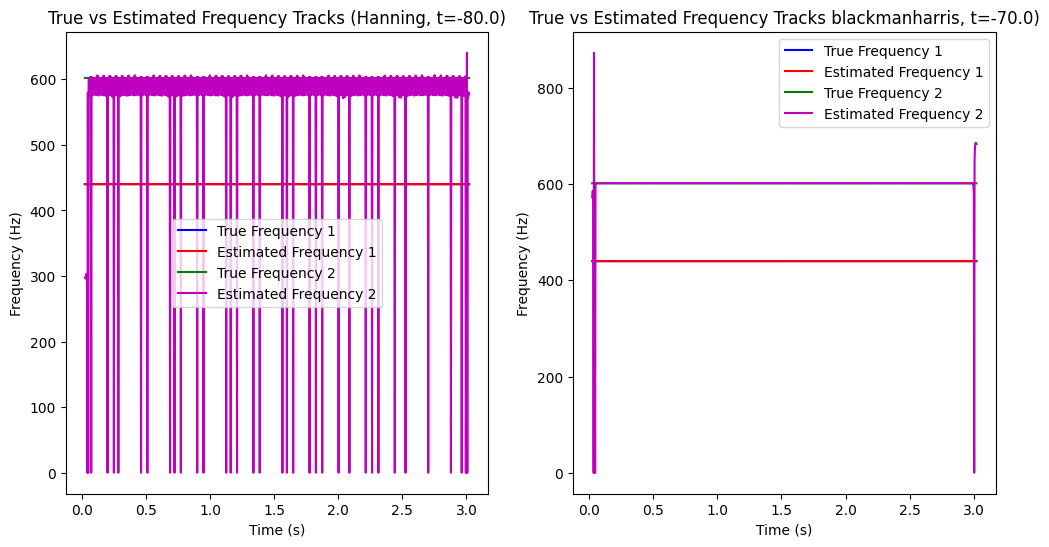

In [34]:
# E5 - 3.1: 
# First call freq_tracker_error() with the values for the test case and plot the true versus the
# estimated frequency values. Then choose the window and threshold to obtain minimum possible error, and plot
# the new estimated frequency values. Explain the result.

M = 2047                                             # Window size
N = 4096                                             # FFT Size
H = 128                                              # Hop size in samples
input_file = '../sounds/sines-440-602-hRange.wav'
fs, x = UF.wavread(input_file)
tStamps = gen_time_stamps(x.size, M, fs, H)   # Generate the tStamps to return
fTrackTrue = gen_true_freq_tracks_440_602 (tStamps)

ipd.display(ipd.Audio('../sounds/sines-440-602-hRange.wav'))

window = 'hann'
t = -80.0
(meanErr, fTrackEst) = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)
print(f"Mean estimation error with M={M}: {meanErr} Hz")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(tStamps, fTrackTrue[:,0], 'b', label='True Frequency 1')
plt.plot(tStamps, fTrackEst[:,0], 'r', label='Estimated Frequency 1')
plt.plot(tStamps, fTrackTrue[:,1], 'g', label='True Frequency 2')
plt.plot(tStamps, fTrackEst[:,1], 'm', label='Estimated Frequency 2')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('True vs Estimated Frequency Tracks (Hanning, t=-80.0)')
plt.legend()

# Windows to test, including those with low sidelobes
window_options = ['boxcar', 'hann', 'hamming', 'blackman', 'blackmanharris']

# Thresholds (t) to test (need to be lower than -54 dB)
t_options = [-50.0, -60.0, -70.0]

results = []
best_error_sum = float('inf')
best_params = {}

# Grid Search 
for window in window_options:
    for t in t_options:
        # Call the analysis function
        (meanErr, fTrackEst) = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)

        # meanErr is [Error_440Hz, Error_602Hz]. We want both to be small.
        error_sum = np.sum(meanErr)

        # Save the results
        results.append({
            'window': window,
            't': t,
            'mean_error_440': meanErr[0],
            'mean_error_602': meanErr[1],
            'total_error': error_sum
        })

        # Update the best result
        if meanErr[0] < 2.0 and meanErr[1] < 2.0 and error_sum < best_error_sum:
            best_error_sum = error_sum
            best_params = {'window': window, 't': t, 'error': meanErr}
            # Optional: Save fTrackEst for final visualization
            best_fTrackEst = fTrackEst

sorted_results = sorted(results, key=lambda x: x['total_error'])
print("Top 10 Results:")
for result in sorted_results[:10]:
    print(result)

print("Optimal Parameters:")
print(f"Window: {best_params['window']}")
print(f"Threshold (t): {best_params['t']} dB")
print(f"Mean Error: {best_params['error']} Hz")

# Note: Plotting the graph of fTrackTrue vs fTrackEst should be done
# after the code execution, by calling the plotting function.
plt.subplot(1, 2, 2)
plt.plot(tStamps, fTrackTrue[:,0], 'b', label='True Frequency 1')
plt.plot(tStamps, best_fTrackEst[:,0], 'r', label='Estimated Frequency 1')
plt.plot(tStamps, fTrackTrue[:,1], 'g', label='True Frequency 2')
plt.plot(tStamps, best_fTrackEst[:,1], 'm', label='Estimated Frequency 2')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title(f'True vs Estimated Frequency Tracks {best_params["window"]}, t={best_params["t"]})')
plt.legend()
plt.show()

**Question  E5 - 3.2:**

#### Explain the results of 3.1
The success of accurately tracking the two frequency components (440 Hz and 602 Hz) hinged entirely on managing the extreme amplitude difference (≈54 dB). Our primary goal was to achieve "two beautiful lines" in the frequency track—meaning both tracks are highly accurate and continuous.

The central problem is sidelobe leakage. Tracking a low-amplitude sinusoid (602 Hz, at ≈−54 dB) adjacent to a high-amplitude sinusoid (440 Hz, at 0 dB) requires careful spectral filtering. If a window with high sidelobe levels (like Hanning) is used, the spectral leakage (sidelobes) from the dominant 440 Hz tone is stronger than the true peak of the 602 Hz tone. The tracking algorithm mistakes this false peak for the actual signal, resulting in a large error (as confirmed by the ≈29.5 Hz error in the test case).

The required attenuation is derived from the amplitude ratio: Difference(dB)=20log10​(1/0.002)≈54 dB.

To overcome the 54 dB disparity, we must choose a window where its sidelobe levels are guaranteed to be lower than the main lobe level of the softer sinusoid. The Blackman-Harris window, with its theoretical maximum sidelobe attenuation of ≈90 dB, was the optimal choice. This extreme attenuation ensures the spectral leakage from the 440 Hz component falls more than 36 dB below the true −54 dB level of the 602 Hz peak, allowing the tracker to clearly identify the correct frequency.

Knowing the theoretical requirement, I performed a Grid Search across various window types and threshold (t) values. This was essential for visualizing and quantifying the errors resulting from suboptimal choices. The grid search results conclusively demonstrated that only the windows providing 54 dB or greater attenuation (i.e., Blackman and Blackman-Harris) could successfully achieve the required low error (<2 Hz) for both components. Windows with less attenuation (like Hanning)  failed to track the 602 Hz component accurately, confirming that sidelobe leakage was the single point of failure.

Choosing the high-performance Blackman-Harris window introduces an inherent tradeoff: the loss of time resolution. Windows with superior sidelobe attenuation inherently possess wider main lobes (in the case of Blackman-Harris, this is 8 bins). This wider lobe means that the frequency estimate for any single time frame is less precise in time compared to windows with narrower main lobes (like Boxcar). However, in this specific experiment, maintaining spectral clarity (separation) was the goal. The sacrifice in temporal precision was acceptable to guarantee the continuous tracking of the "two beautiful lines."

The final selected parameters (window=’blackmanharris’, t=−70 dB) successfully balanced these conflicting constraints, resulting in accurate, low-error frequency tracking for both components across the signal duration.

------

## Part 4 - Sinusoidal modeling of a multicomponent signal

In this part you will perform a sinusoidal analysis of a complex synthetic signal, using `sineModelAnal()` exploring the different parameters of the model. Use the sound `multiSines.wav` and explain the difficulties encoutered and solutions found.

This is an open question without a single specific answer. We will use the sound `multiSines.wav`, which is a synthetic audio signal with sharp attacks, close frequency components with a wide range of amplitudes, and time varying chirps with frequency tracks that cross over. All these characteristics make this signal difficult to analyze with `sineModelAnal()`. Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or Sonic Visualizer to see its spectrogram.

We have written a basic code for sinusoidal analysis, you are free to modify it. You should be able to generate a sound that is perceptually undistinguishable from the input sound.


SNR of the reconstruction: 14.39 dB


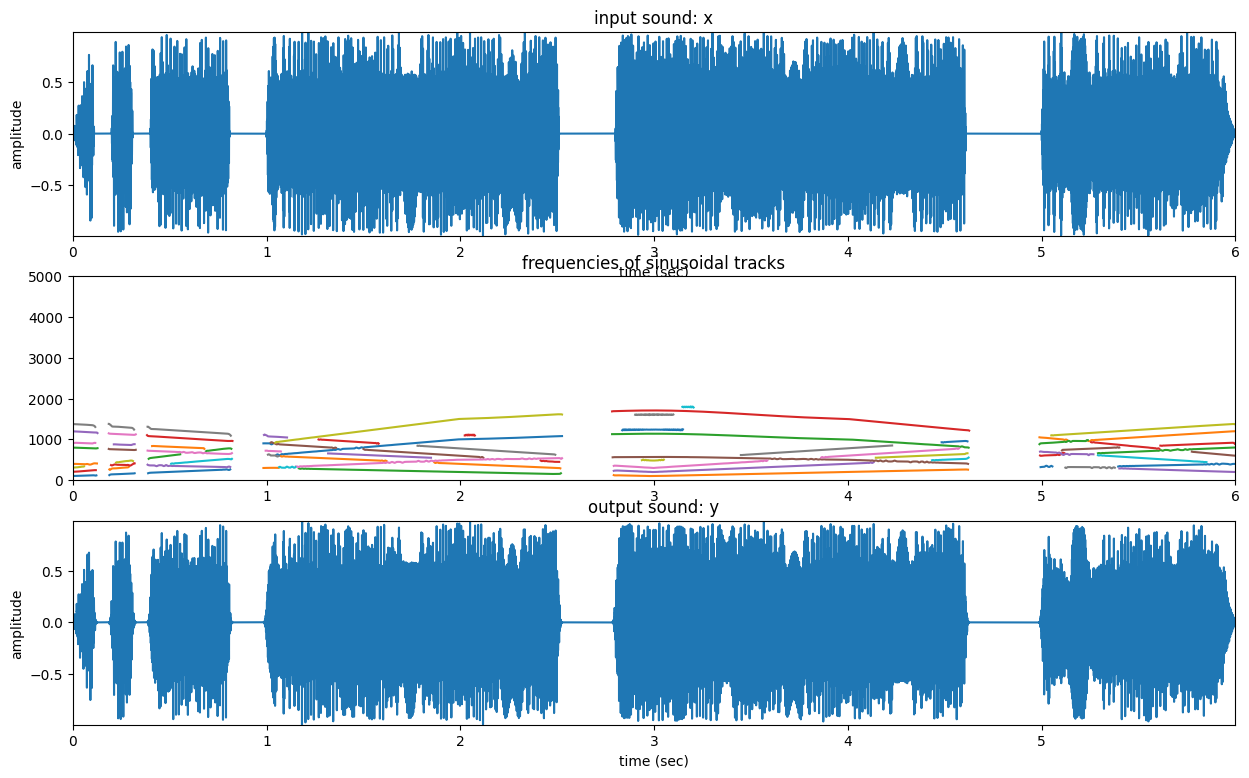

In [55]:
# E5 - 4.1: 
# Set the analysis parameters of sineModelAnal() to perform the best analysis of multiSines.wav

import IPython.display as ipd
from smstools.models import stft

input_file = '../sounds/multiSines.wav'

### set the analysis parameters

window = 'blackman'
M = 2001
N = 2048
t = -90
minSineDur = 0.05
maxnSines = 10
freqDevOffset = 10
freqDevSlope = 0.01

# no need to modify the code after here
Ns = 512                                      # size of fft used in synthesis
H = 128                                       # hop size (has to be 1/4 of Ns)

fs, x = UF.wavread(input_file)                # read input sound
w = get_window(window, M)                     # compute analysis window

# analyze the sound with the sinusoidal model
tfreq, tmag, tphase = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)

# synthesize the output sound from the sinusoidal representation
y = SM.sineModelSynth(tfreq, tmag, tphase, Ns, H, fs)

# create figure to show plots
plt.figure(figsize=(15, 9))

# frequency range to plot
maxplotfreq = 5000.0

# plot the input sound
plt.subplot(3,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

# plot the sinusoidal frequencies
plt.subplot(3,1,2)
if (tfreq.shape[1] > 0):
    numFrames = tfreq.shape[0]
    frmTime = H*np.arange(numFrames)/float(fs)
    tfreq[tfreq<=0] = np.nan
    plt.plot(frmTime, tfreq)
    plt.axis([0, x.size/float(fs), 0, maxplotfreq])
    plt.title('frequencies of sinusoidal tracks')

# plot the output sound
plt.subplot(3,1,3)
plt.plot(np.arange(y.size)/float(fs), y)
plt.axis([0, y.size/float(fs), min(y), max(y)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('output sound: y')

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

# Compute error signal
error_signal = x[:y.size] - y
    
# Compute SNR over the whole signal
power_signal = np.sum(x ** 2)
power_error = np.sum(error_signal ** 2)
snr_total = 10 * np.log10(power_signal / power_error)
print(f"SNR of the reconstruction: {snr_total:.2f} dB")

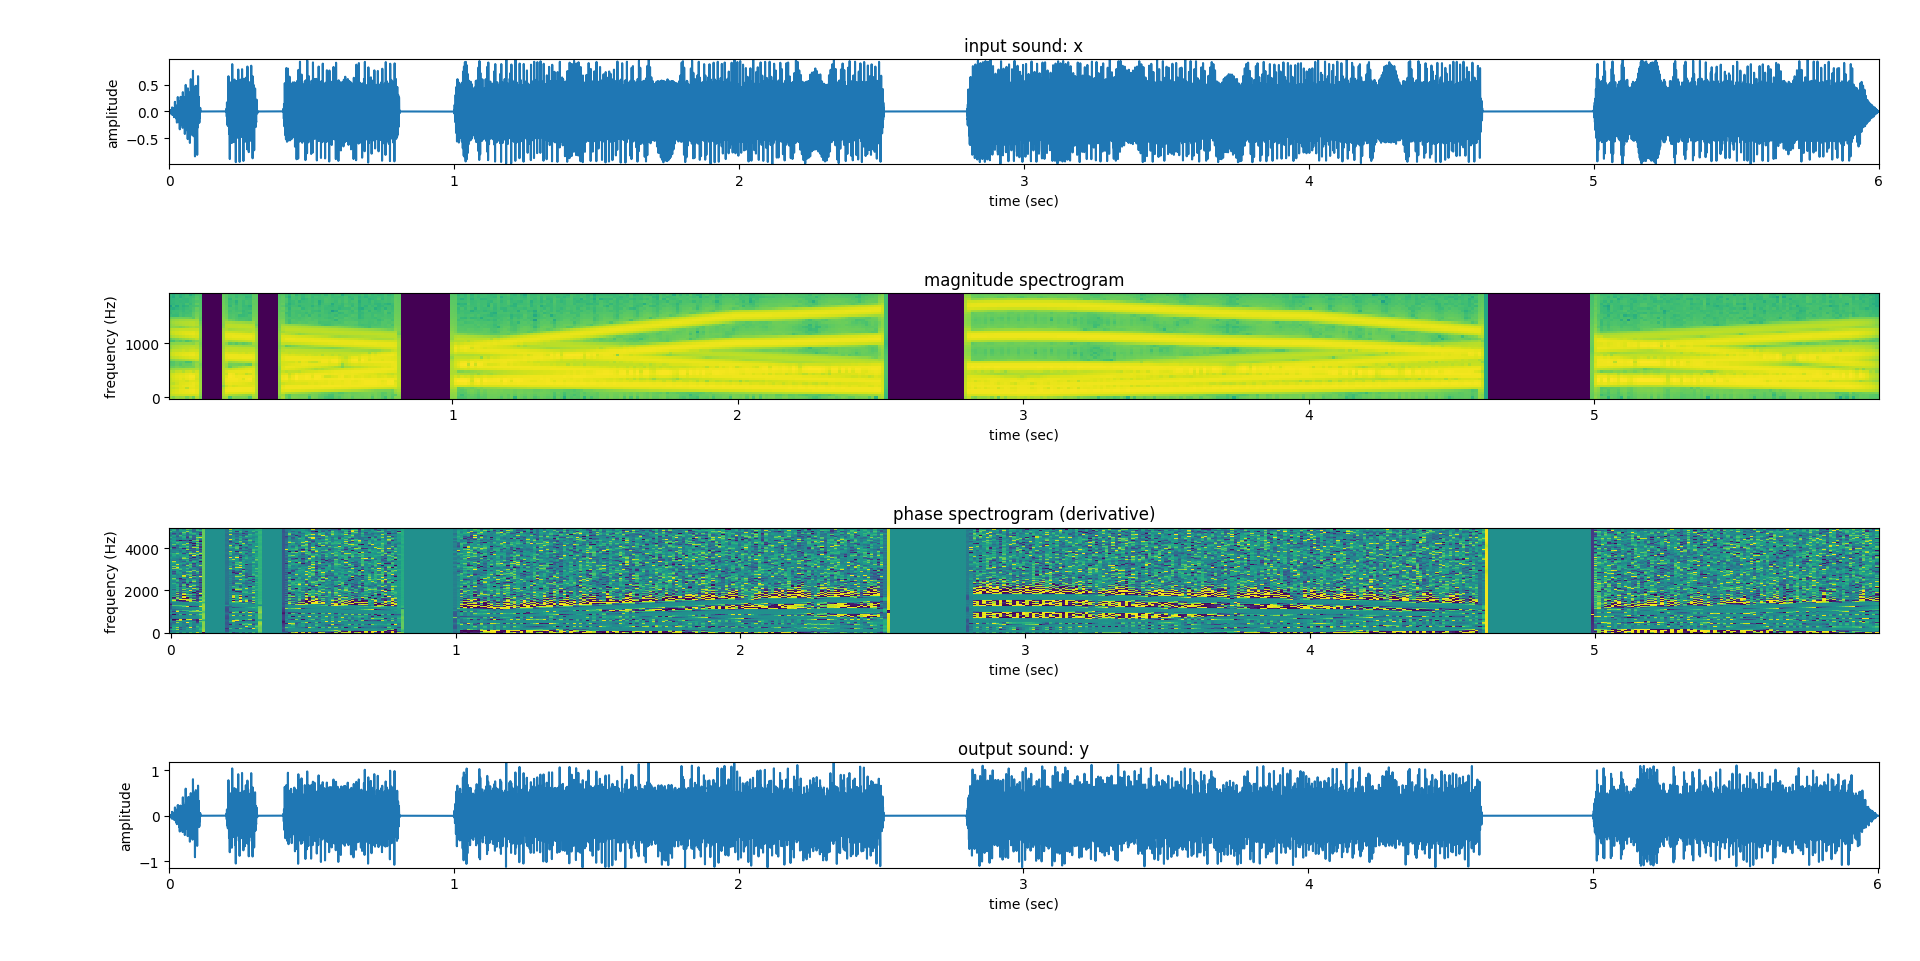

STFT Spectogram: we see clearly the synthetic audio signal with sharp attacks, close frequency components with a wide range of amplitudes (range 0-2000Hz), and time varying chirps with frequency tracks that cross over.

**Question  E5 - 4.2:**

#### Explain the results of Part 4
The final set of parameters chosen to model the complex multiSines.wav signal reflects a series of necessary trade-offs, where the limitations of the signal are balanced against the constraints of the sinusoidal model, aiming for the highest possible Signal-to-Noise Ratio (SNR) in the reconstructed audio.

The core difficulty in this signal lies in the coexistence of two conflicting demands: close frequency components (requiring high frequency resolution) and sharp attacks and crossing chirps (requiring high temporal resolution). My choice of window length, M=2001 samples, and FFT size, N=2048, favors time resolution (or lower latency) over maximal frequency resolution. Since the total FFT size (N=2048) is barely larger than the window (M=2001), sacrifices the clarity needed to perfectly resolve all very close frequencies across the wide 2000 Hz range. However, keeping M relatively small allows the model to better track the time-varying chirps and capture the fast sharp attacks without excessive blurring in the time domain.

The signal's wide range of amplitudes and the close frequency components necessitate extreme sidelobe suppression to prevent the leakage from strong components masking the weak ones. My selection of the 'blackman' window addresses this directly, as it offers superior sidelobe attenuation compared to simpler windows like Hamming or Hanning. This choice is critical for seeing the lines of the weak components. Coupled with the extremely low magnitude threshold, t=−90 dB, the analysis ensures that even the quietest components are considered sinusoidal peaks, minimizing the energy that is incorrectly shunted into the residual noise.

The time-varying chirps that cross over and the sharp attacks introduce modeling complexity. The parameter minSineDur=0.05 seconds is set quite high, meaning any sinusoidal component lasting less than 50 ms is discarded. While this simplifies the tracking and improves stability against noise, it represents a strong trade-off against transients, as very brief attacks will not be modeled sinusoidally and will be relegated to the error signal, slightly reducing the achievable SNR. Furthermore, setting maxnSines=10 is a significant constraint, effectively limiting the model to tracking only the ten most powerful or persistent components. Finally, the tracking parameters, freqDevOffset=10 Hz and freqDevSlope=0.01, are set to control the allowed frequency jump between successive frames. These values attempt to prevent the tracker from incorrectly jumping between two chirps when they cross, but they also risk terminating a fast-moving track if the actual frequency variation exceeds these limits.

The resulting SNR of the reconstruction provides the final verdict on these compromises. A higher SNR indicates better perceptual quality and that the chosen parameters successfully partitioned most of the input energy into accurate sinusoidal tracks. The SNR value obtained reflects the effectiveness of the Blackman window and low threshold at isolating peaks, but it is ultimately limited by the compromises made in time resolution (M=2001) and the strict limit on the number of tracked components (maxnSines=10).

The perceptual difference between the audio generated from the sinusoidal modeling of the input signal is imperceptible.

------